## <u>Bigmart Sales Data Prediction</u> ##
#### The data set represents the 2013 sales data of a retail chain for 1559 products across 10 stores in different cities. Ultimate aim would be to build a predictive model and find out the sales of each product at a particular store ####   
## <u>Objective:</u> ##
#### The objective of the current analysis is to use different Regression models, like for example Linear Regression, Ridge, Random Forest, Gradientboosting, XGBoost to predict the sales of the outlet and see which one performs the best ####   


### <u>Importing all the necessary libraries </u> ###

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import math

from sklearn.preprocessing import OneHotEncoder,StandardScaler, MinMaxScaler,PolynomialFeatures

from sklearn.model_selection import KFold, GridSearchCV,train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor  
import xgboost 
from xgboost import XGBRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

### <u>Reading the files </u> ###

In [3]:
path1 = 'Sales_data.csv'
sales = pd.read_csv(path1)

### <u>Preprocessing and Data Cleaning </u> ###

In [4]:
sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
print("The shape of train data is : {}".format(sales.shape))

The shape of train data is : (8523, 12)


#### Types of Items being sold ####

In [6]:
sales['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [7]:
sales['Item_Type'].nunique()

16

In [8]:
sales.info(verbose = True, null_counts= True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


> ##### One can see above that max number of row entries are 8523 and some of the Columns have empty values - e.g Item Weight has only 7060 entries, Outlet_Size has only 6113 entries. 
> ##### One would need to clean the data, i.e. to impute these missing values later 

In [9]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


#### Treating missing values ####
> Three things would be needed to be dealt here : __'Outlet_Size', 'Item_Weight' and 'Item_Visibility'__
> 1. Since __'Outlet_Size'__ is a categorical column, we can impute it with the mode value, i.e. 'Medium' here

In [10]:
print('Outlet_Size :\n',sales['Outlet_Size'].value_counts(), '\n')
print('Item_Weight :\n',sales['Item_Weight'].value_counts(), '\n')

Outlet_Size :
 Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64 

Item_Weight :
 12.150    86
17.600    82
13.650    77
11.800    76
15.100    68
          ..
7.560      2
9.420      1
5.400      1
6.520      1
7.685      1
Name: Item_Weight, Length: 415, dtype: int64 



In [11]:
sales_M = sales.copy()

In [12]:
## replacing the missing values 
sales_M['Outlet_Size'] = sales['Outlet_Size'].fillna(sales['Outlet_Size'].dropna().mode().values[0])

## check if missing values are filled
print(sales_M['Outlet_Size'].isnull().sum())

0


> 2. Since __'Item_Weight'__ is a numerical column, we have to visualize it to understand a bit more

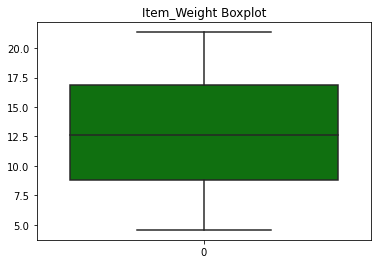

In [13]:
sns.boxplot(data = sales['Item_Weight'], color = 'g')
plt.title('Item_Weight Boxplot');

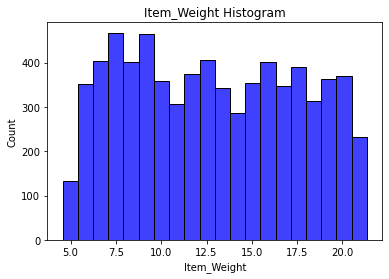

In [14]:
sns.histplot(data = sales['Item_Weight'], color = 'b')
plt.title('Item_Weight Histogram');

> since no outliers are there and the data doesn't seem to be much skewed, we can replace the missing values with the mean value for maximum efficiency 

In [15]:
sales_M['Item_Weight'] = sales_M['Item_Weight'].fillna(sales_M['Item_Weight'].dropna().mean())

## check if missing values are filled
sales_M['Item_Weight'].isnull().sum()

0

> 3. __'Item_Visibility'__ has entries with values 0.0 which doesn't make sense as no items could be allocated zero space in reality. One has to see how many '0.0' values are there

In [16]:
sales_M['Item_Visibility'].value_counts()

0.000000    526
0.076975      3
0.041283      2
0.085622      2
0.187841      2
           ... 
0.092576      1
0.067544      1
0.115168      1
0.146896      1
0.050902      1
Name: Item_Visibility, Length: 7880, dtype: int64

> Since, there are a huge number of '0.0' values, we will replace these values with the median of all the rest of the values

In [17]:
median_visib = sales_M['Item_Visibility'][sales_M['Item_Visibility'] > 0.00000].median()
print("Mean of 'Item_Visibility' with values > '0.0' : ",median_visib)

Mean of 'Item_Visibility' with values > '0.0' :  0.057792342999999996


In [18]:
sales_M.loc[sales_M['Item_Visibility'] == 0.0, 'Item_Visibility'] = median_visib

In [19]:
sales_M['Item_Visibility'].value_counts()

0.057792    527
0.076975      3
0.076483      2
0.026950      2
0.135708      2
           ... 
0.164197      1
0.092576      1
0.067544      1
0.115168      1
0.037218      1
Name: Item_Visibility, Length: 7879, dtype: int64

> **One can recheck the dataframe information for missing values:**

In [20]:
print('Sales Data: \n')
print(sales_M.info(verbose = True, null_counts= True))

Sales Data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None


> One sees above that there are no more missing values

### <u> Exploratory Data Analysis </u> ###

> One can store the categorical and numerical columns into separate lists for later use

In [21]:
## numeric columns
numer = sales_M.select_dtypes('number').columns.to_list()
## categorical columns
categ = sales_M.select_dtypes('object').columns.to_list()
## print the valuecounts for all the categorical data
[sales_M[cat].value_counts() for cat in categ[1:]]

[Low Fat    5089
 Regular    2889
 LF          316
 reg         117
 low fat     112
 Name: Item_Fat_Content, dtype: int64,
 Fruits and Vegetables    1232
 Snack Foods              1200
 Household                 910
 Frozen Foods              856
 Dairy                     682
 Canned                    649
 Baking Goods              648
 Health and Hygiene        520
 Soft Drinks               445
 Meat                      425
 Breads                    251
 Hard Drinks               214
 Others                    169
 Starchy Foods             148
 Breakfast                 110
 Seafood                    64
 Name: Item_Type, dtype: int64,
 OUT027    935
 OUT013    932
 OUT046    930
 OUT049    930
 OUT035    930
 OUT045    929
 OUT018    928
 OUT017    926
 OUT010    555
 OUT019    528
 Name: Outlet_Identifier, dtype: int64,
 Medium    5203
 Small     2388
 High       932
 Name: Outlet_Size, dtype: int64,
 Tier 3    3350
 Tier 2    2785
 Tier 1    2388
 Name: Outlet_Location_Type,

> #### One can see that 'Item_Fat_Content' has repeating values. One can change these values with two categories : 'Low Fat' and 'Regular' ####

In [22]:
sales_M['Item_Fat_Content'].replace(['LF','reg','low fat'], ['Low Fat','Regular','Low Fat'], inplace=True)
sales_M['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

> #### Since the establishment year doesn't give a lot of info, we can replace it with the age of store (from year 2021) and drop the original column ####

In [23]:
sales_M['Outlet_Age'] = sales_M['Outlet_Establishment_Year'].apply(lambda x: 2021-x)
sales_M = sales_M.drop('Outlet_Establishment_Year', axis = 1)
sales_M.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,22
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,12
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,22
3,FDX07,19.20,Regular,0.057792,Fruits and Vegetables,182.0950,OUT010,Medium,Tier 3,Grocery Store,732.3800,23
4,NCD19,8.93,Low Fat,0.057792,Household,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,34


> #### The Columns 'Item_Identifier' and 'Outlet_Identifier' are non-numerical values which won't help us in our regression problem. Hence they can be dropped ####

In [24]:
sales_M = sales_M.drop('Item_Identifier', axis = 1)
sales_M = sales_M.drop('Outlet_Identifier', axis = 1)

In [25]:
sales_M.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
0,9.30,Low Fat,0.016047,Dairy,249.8092,Medium,Tier 1,Supermarket Type1,3735.1380,22
1,5.92,Regular,0.019278,Soft Drinks,48.2692,Medium,Tier 3,Supermarket Type2,443.4228,12
2,17.50,Low Fat,0.016760,Meat,141.6180,Medium,Tier 1,Supermarket Type1,2097.2700,22
3,19.20,Regular,0.057792,Fruits and Vegetables,182.0950,Medium,Tier 3,Grocery Store,732.3800,23
4,8.93,Low Fat,0.057792,Household,53.8614,High,Tier 3,Supermarket Type1,994.7052,34


### <u> Data Visualization </u> ###

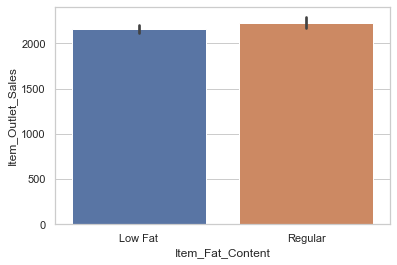

In [26]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Item_Fat_Content", y="Item_Outlet_Sales", data=sales_M)

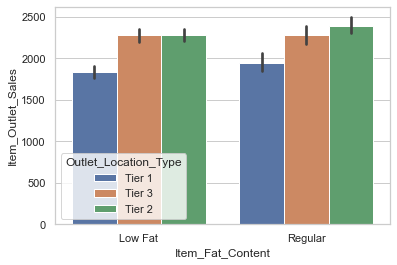

In [27]:
ax = sns.barplot(x="Item_Fat_Content", y="Item_Outlet_Sales", hue='Outlet_Location_Type',data=sales_M)

> *1. One can see that sales of __'Regular'__ Fat content is slightly higher than __'Low Fat'__*    
> *2. __Tier2__ cities have more sales overall than __Tier1__ cities*

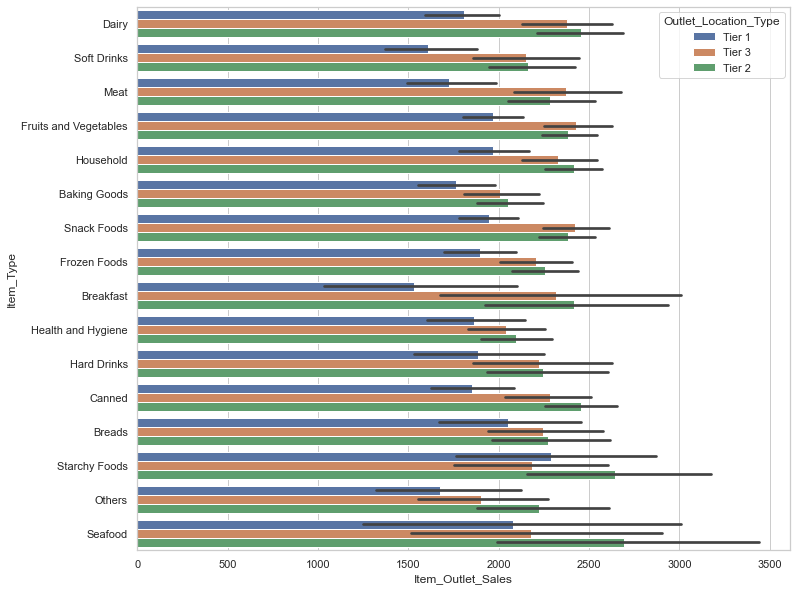

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 10)
sns.barplot(y="Item_Type", x="Item_Outlet_Sales", hue='Outlet_Location_Type',data=sales_M, ax=ax, orient='h');

> *From above, one can see that for almost all the Item_Types, __Tier2__ cities have highest sales and __Tier1__ cities have lowest sales*

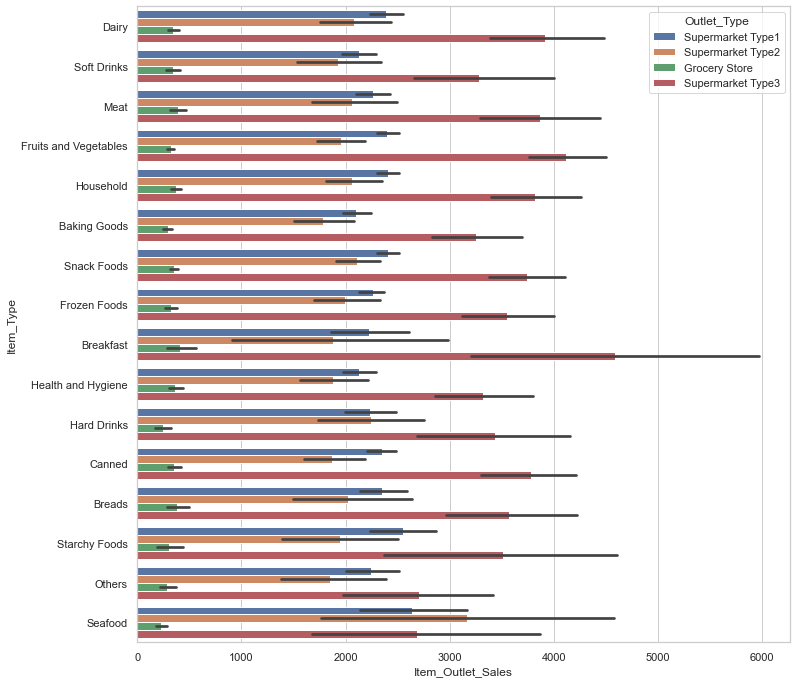

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 11.7)
sns.barplot(y="Item_Type", x="Item_Outlet_Sales", hue='Outlet_Type',data=sales_M, ax=ax, orient='h');

> *From above, one can see that for almost all the Item_Types, __Supermarket Type3__ has highest sales and __Grocery Store__ has lowest sales*

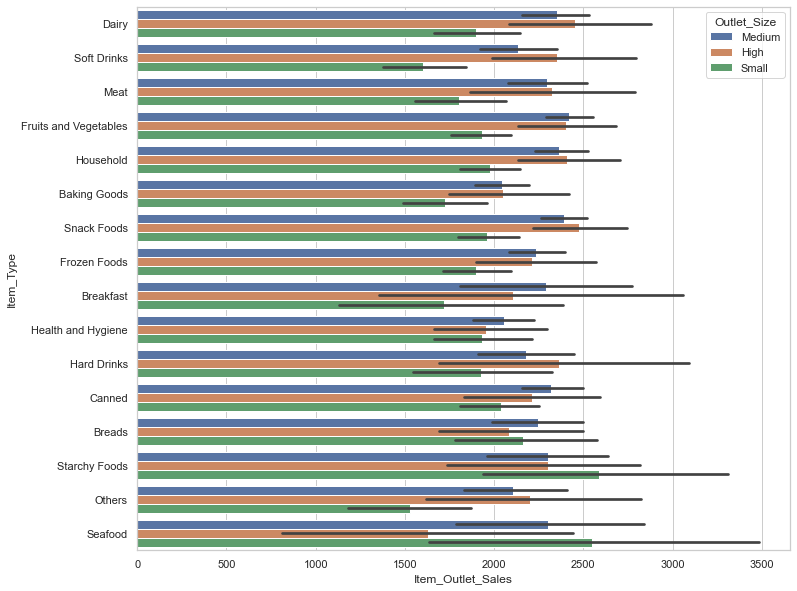

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 10)
sns.barplot(y="Item_Type", x="Item_Outlet_Sales", hue='Outlet_Size',data=sales_M, ax=ax, orient='h');

> *For the __'Outlet_Size'__, the behaviour is mixed. __'Small'__ size outlet has more sales for starchy foods, others and Seafood categories while for other Item types, __'Medium'__ and __'High'__ sized stores have higher sales*

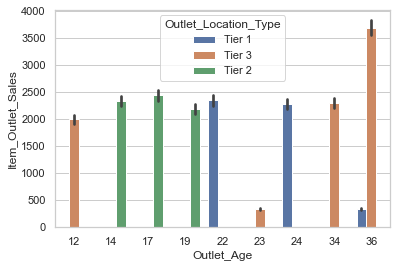

In [31]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Outlet_Age", y="Item_Outlet_Sales",hue='Outlet_Location_Type', data=sales_M)

> *Apparently the oldest store in __Tier3__ city has the highest sales*

### <u> Feature Engineering </u> ###   
#### <u> One-hot encoding :</u> ####    
For the prediction purposes, one-hot encoding will be done for the categorical columns. A new dataframe will be created for this.

In [32]:
categ = sales_M.select_dtypes('object').columns.to_list()
num_ohc_cols = (sales_M[categ].apply(lambda x : x.nunique()).sort_values(ascending=False))
sales_Mohc = sales_M.copy()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    #One hot encode this data - this returns a sparse array
    new_dat = ohc.fit_transform(sales_Mohc[[col]])
    
    #drop original column from Dataframe
    sales_Mohc = sales_Mohc.drop(col, axis=1)
    
    #get names of all unique elements so that one can identify them later
    cats = ohc.categories_
    
    #Create column names for each OHE column by value
    new_cols = ['_'.join([col,cat]) for cat in cats[0]]
    
    #create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(),columns=new_cols)
    
    #Append the new data to the dataframe
    sales_Mohc = pd.concat([sales_Mohc,new_df], axis=1)

In [33]:
sales_Mohc.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Outlet_Age,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular
0,9.30,0.016047,249.8092,3735.1380,22,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,5.92,0.019278,48.2692,443.4228,12,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,17.50,0.016760,141.6180,2097.2700,22,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,19.20,0.057792,182.0950,732.3800,23,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,8.93,0.057792,53.8614,994.7052,34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


#### <u> Skew :</u> ####    
For the better prediction purposes, the features need to be normally distributed. Hence all the not one-hot encoded numeric columns will be checked for skewness and a cut-off limit of 0.75 will be used. Those higher than this will be normalized using a ***np.sqrt*** transformation. (___Numeric columns will be the ones having more than 2 unique values___)

In [34]:
mask2 = sales_Mohc.apply(lambda x: x.nunique())>2
numer_cols = sales_Mohc.columns[mask2]

In [35]:
skew_limit = 0.75
skew_vals = sales_Mohc[numer_cols].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))
skew_cols

,Skew
Item_Visibility,1.310871
Item_Outlet_Sales,1.177531


> Since ___'Item_Outlet_Sales'___ is out target variable, it wont be transformed. So, only ***'Item_Visibility'*** will be transformed

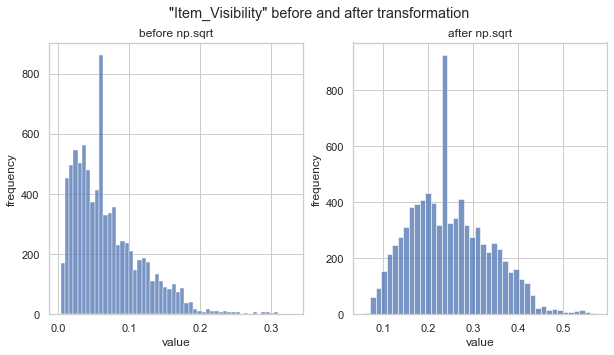

In [36]:
field = 'Item_Visibility'
fig, (ax_before, ax_after) = plt.subplots(1,2,figsize=(10,5))
sns.histplot(data= sales_Mohc['Item_Visibility'],ax = ax_before)
sns.histplot(data= sales_Mohc['Item_Visibility'].apply(np.sqrt),ax = ax_after)
ax_before.set(title='before np.sqrt', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.sqrt', ylabel='frequency', xlabel='value')
fig.suptitle('"{}" before and after transformation'.format(field));

In [37]:
sales_Mohc['Item_Visibility'] = sales_Mohc['Item_Visibility'].apply(np.sqrt)

### <u> Regression Models </u> ###   
#### Following Regression Models will be used to train and test the data here ####

1. Linear Regression
2. Ridge Regression
3. Random forest
4. Gradient Boosting
5. XGBoost

In [38]:
feature_cols = [x for x in sales_Mohc.columns if x!='Item_Outlet_Sales']
feature_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Age',
 'Item_Type_Baking Goods',
 'Item_Type_Breads',
 'Item_Type_Breakfast',
 'Item_Type_Canned',
 'Item_Type_Dairy',
 'Item_Type_Frozen Foods',
 'Item_Type_Fruits and Vegetables',
 'Item_Type_Hard Drinks',
 'Item_Type_Health and Hygiene',
 'Item_Type_Household',
 'Item_Type_Meat',
 'Item_Type_Others',
 'Item_Type_Seafood',
 'Item_Type_Snack Foods',
 'Item_Type_Soft Drinks',
 'Item_Type_Starchy Foods',
 'Outlet_Type_Grocery Store',
 'Outlet_Type_Supermarket Type1',
 'Outlet_Type_Supermarket Type2',
 'Outlet_Type_Supermarket Type3',
 'Outlet_Location_Type_Tier 1',
 'Outlet_Location_Type_Tier 2',
 'Outlet_Location_Type_Tier 3',
 'Outlet_Size_High',
 'Outlet_Size_Medium',
 'Outlet_Size_Small',
 'Item_Fat_Content_Low Fat',
 'Item_Fat_Content_Regular']

In [39]:
x_train,x_test,y_train,y_test = train_test_split(sales_Mohc[feature_cols],
                                                 sales_Mohc['Item_Outlet_Sales'],
                                                 test_size=0.3,
                                                random_state=42)

In [40]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((5966, 32), (2557, 32), (5966,), (2557,))

In [41]:
kf = KFold(shuffle = True, random_state=42, n_splits = 5)
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [42]:
def predict(model,model_name):
    model.fit(x_train,y_train)
    print("The best score for {} model is {:.4f}".format(model_name,model.best_score_))
    print("The best parameters for {} model are {}".format(model_name,model.best_params_))
    ypred = model.predict(x_test)
    r2 = r2_score(y_test,ypred)
    rmse_m = rmse(y_test,ypred)
    print(" The R2 score for {} model is {:.4f}".format(model_name,r2))
    print(" The RMSE for {} model is {:.4f}".format(model_name,rmse_m))
    return ypred,r2,rmse_m

> A Function which takes a model as an input and returns the respective predicted values, R2_score and RMSE on the hold out set

#### 1. <u>Linear Regression</u>

In [43]:
estimator_lr = Pipeline([
                ('polynomial_features',PolynomialFeatures()),
                ('scaling',StandardScaler()),
                ('linear_regression',LinearRegression())])
params_lr = {
        'polynomial_features__degree': [1,2,3],
        }
grid_lr = GridSearchCV( estimator_lr, params_lr, cv=kf)

#### Predicted values and Error Metrics : R2 score and RMSE

In [44]:
ypred_lr,r2_lr,rmse_lr = predict(grid_lr,'linear_regression')

The best score for linear_regression model is 0.5547
The best parameters for linear_regression model are {'polynomial_features__degree': 1}
 The R2 score for linear_regression model is 0.5675
 The RMSE for linear_regression model is 1100.6659


#### 2. <u>Ridge Regression</u>

In [45]:
estimator_rr = Pipeline([
                ('polynomial_features',PolynomialFeatures()),
                ('scaling',StandardScaler()),
                ('ridge_regression',Ridge())])
params_rr = {
        'polynomial_features__degree': [1,2,3],
        'ridge_regression__alpha': [1,3,5,10,15,30,80,100,150,200]
        }
grid_rr = GridSearchCV( estimator_rr, params_rr, cv=kf)

#### Predicted values and Error Metrics : R2 score and RMSE

In [46]:
ypred_rr,r2_rr,rmse_rr = predict(grid_rr,'ridge_regression')

The best score for ridge_regression model is 0.5840
The best parameters for ridge_regression model are {'polynomial_features__degree': 2, 'ridge_regression__alpha': 200}
 The R2 score for ridge_regression model is 0.5917
 The RMSE for ridge_regression model is 1069.4565


#### 3. <u>Random Forest</u>

In [47]:
param_grid = {'max_depth':[3,5,8],
              'max_features':['auto','sqrt'],
             'n_estimators':[100,150,200,300],
             'criterion':['mse','mae']}

grid_RF = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, n_jobs=-1,cv=kf)

#### Predicted values and Error Metrics : R2 score and RMSE

In [48]:
ypred_RF,r2_RF,rmse_RF = predict(grid_RF,'random_forest')

The best score for random_forest model is 0.5925
The best parameters for random_forest model are {'criterion': 'mse', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}
 The R2 score for random_forest model is 0.6015
 The RMSE for random_forest model is 1056.4798


#### 4. <u>Gradient Boost</u>

In [49]:
param_grid={'learning_rate':[0.1,0.01,0.001],                         
            'max_depth':[3,5,8],
            'subsample':[1,0.5],                                                             
            'n_estimators':[100,150,200,300],                                                             
            'max_features':['auto','sqrt']}

grid_GBR = GridSearchCV(GradientBoostingRegressor(criterion='friedman_mse'),param_grid = param_grid, n_jobs=-1,cv=kf)

#### Predicted values and Error Metrics : R2 score and RMSE

In [50]:
ypred_GBR,r2_GBR,rmse_GBR = predict(grid_GBR,'gradient_boost')

The best score for gradient_boost model is 0.5928
The best parameters for gradient_boost model are {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 300, 'subsample': 0.5}
 The R2 score for gradient_boost model is 0.6011
 The RMSE for gradient_boost model is 1057.0512


#### 5. <u>Extreme Gradient Boost (XGBoost)</u>

In [51]:
param_grid = {'learning_rate':[0.1,0.01,0.001],
              'max_depth':[3,5,8],
              'num_feature':[10,20,32],
              'n_estimators':[100,150,200,300],
             'subsample':np.linspace(0.1,1,10),
            'colsample_bytree':np.linspace(0.1,1,10)
            }
grid_xgb = GridSearchCV(XGBRegressor(eval_metric='rmse'),param_grid = param_grid, n_jobs=-1,cv=kf)

#### Predicted values and Error Metrics : R2 score and RMSE

In [52]:
ypred_xgb,r2_xgb,rmse_xgb = predict(grid_xgb,'xgboost')

The best score for xgboost model is 0.5944
The best parameters for xgboost model are {'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_feature': 32, 'subsample': 1.0}
 The R2 score for xgboost model is 0.5991
 The RMSE for xgboost model is 1059.6342


### <u>Best Model</u> ###   

> *From the above one can clearly see that the Tree Models perform better and faster than the linear Regression models. Among the tree models, all are quite near in their error_metrics in terms of prediction. But __Random forest__ has the best metrics among all. Hence this would be the model of choice here*   
    
> *A comparison of all the models with their scores is shown below*

In [53]:
r2_ = [r2_lr,r2_rr,r2_RF,r2_GBR,r2_xgb]
rmse_ = [rmse_lr,rmse_rr,rmse_RF,rmse_GBR,rmse_xgb]
model_ = [grid_lr,grid_rr,grid_RF,grid_GBR,grid_xgb]
model_names = ['Linear_Regression','Ridge_Regression','Random_Forest','Gradient_Boosting','XGBoost']
metrics = list()

In [54]:
for i,mod in enumerate(model_names):
    metrics.append(pd.Series({'r2_score':r2_[i], 
                              'RMSE':rmse_[i],
                             },
                            name=mod))

metrics = pd.concat(metrics, axis=1)

In [55]:
metrics

,Linear_Regression,Ridge_Regression,Random_Forest,Gradient_Boosting,XGBoost
r2_score,0.567487,0.591667,0.601517,0.601085,0.599133
RMSE,1100.665856,1069.456491,1056.479808,1057.051226,1059.634152


#### <u>Feature Importances</u> ####

In [56]:
feature_importances = pd.DataFrame(grid_RF.best_estimator_.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [57]:
feature_importances.head(5)

,importance
Item_MRP,0.557310
Outlet_Type_Grocery Store,0.313716
Outlet_Type_Supermarket Type3,0.071507
Outlet_Age,0.051669
Item_Visibility,0.003265


> *One can see from the above the top 5 features with highest importance, which affect the sales prediction. Apparently __'Item_MRP'__ and Outlet_Type of __'Grocery_store'__ have the maximum influence on the sales. Also interestingly, __'Outlet_Age'__ shows a high coefficient. Which means the customers stay loyal to the older stores*

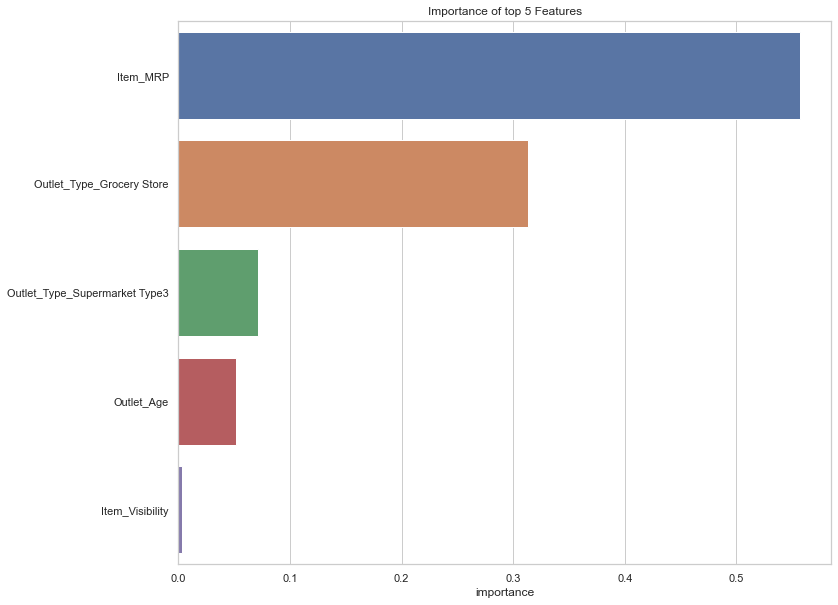

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 10)
ax1 = sns.barplot(y=feature_importances.index[:5], x=feature_importances["importance"].iloc[:5], data=feature_importances, ax=ax, orient='h')
ax1.set_title('Importance of top 5 Features');